# Классификация с помощью алгоритма KNN


In [482]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# Информация о датасете

Датасет содержит содержит информацию о доступных вакансиях. Цель: определить настоящая ли это вакансия.

Описание с сайта источника:

This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

# Загрузка Данных

In [483]:
df = pd.read_csv("fake_job_postings.csv")
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


Исходные столбцы:

In [484]:
print(*df.columns, sep=", ")

job_id, title, location, department, salary_range, company_profile, description, requirements, benefits, telecommuting, has_company_logo, has_questions, employment_type, required_experience, required_education, industry, function, fraudulent


# Предобработка данных


In [485]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Удалю неинтересные столбцы

In [486]:
del_cols=['job_id','location','department','salary_range','description','title','company_profile','benefits','requirements']

Заодно обработаю пропущенные данные

In [487]:
df=df.drop(del_cols,axis=1)
col_list=list(df.columns)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for i in col_list:
    if df[i].dtype=='object':
        df[i]=df[i].replace(np.nan,df[i].mode()[0],regex=True)

df.isnull().sum()
df

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,Bachelor's Degree,Information Technology and Services,Marketing,0
1,0,1,0,Full-time,Not Applicable,Bachelor's Degree,Marketing and Advertising,Customer Service,0
2,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
17876,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0
17878,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0



Ниже представлены некоторые метрические характеристики числовых признаков:

count - число значений
mean - среднее арифметическое
std - разброс
min - минимальное значение
max - максимальное значение

In [488]:
df.describe()



,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000



Можно вычислить матрицу корреляции, чтобы выявить возможные связи признаков между собой (а вернее, их отсутствие - ввиду тематики датасета большинство признаков являются совершенно независимыми "по определению").

In [489]:
corr_mat = df.corr()
corr_mat


,telecommuting,has_company_logo,has_questions,fraudulent
telecommuting,1.000000,-0.019836,0.020345,0.034523
has_company_logo,-0.019836,1.000000,0.233932,-0.261971
has_questions,0.020345,0.233932,1.000000,-0.091627
fraudulent,0.034523,-0.261971,-0.091627,1.000000


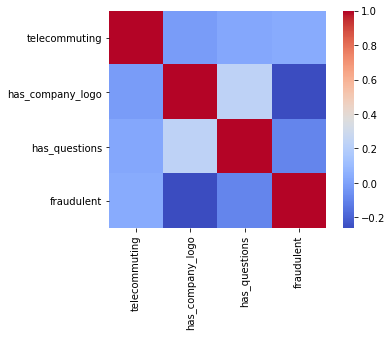

In [490]:
seaborn.heatmap(corr_mat, square=True, cmap="coolwarm")
pass

# Классификация 
Проведем классификацию с помощью нескольких алгоритмов машинного обучения и сравним результаты. Для работы с моделями будут использоваться все выбранные признаки. Разобью данные на тренировочную и тестовую выборку.

In [491]:


from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for i in col_list:
    if df[i].dtype=='object':
        df[i]=le.fit_transform(df[i])

y=df['fraudulent']

x=df.drop(['fraudulent'],axis=1)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)


# KNN

In [492]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)
"Train: {}, Test: {}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

'Train: 0.9674217002237137, Test: 0.9664429530201343'

# Logistic Regression



In [493]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(x_train,y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)
"Train: {}, Test: {}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

'Train: 0.951761744966443, Test: 0.9577740492170023'

# RFClassifier

In [494]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
y_train_pred = rfc.predict(x_train)
y_test_pred = rfc.predict(x_test)
"Train: {}, Test: {}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

'Train: 0.9811940715883669, Test: 0.9751118568232662'